# Bump test following errors vs time

In [1]:
# Times Square parameters

t_start = "2024-11-04T12:00:00"
t_end = "2024-11-14T12:00:00"
id = 409


In [2]:
import asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from astropy.time import Time, TimeDelta
from lsst.ts.xml.tables.m1m3 import FATable, FAIndex, force_actuator_from_id, actuator_id_to_index
from lsst_efd_client import EfdClient
from lsst.ts.xml.enums.MTM1M3 import BumpTest
plt.set_loglevel('WARNING') 

In [6]:
def max_error(errors):
    return np.max([np.max(errors), np.max(errors * -1.0)])
    
def rms_times(t_start):
    # This is the date of the IRQ change, which changed the bump test timings
    change_date = Time("2024-10-12T00:00", format='isot', scale='utc')
    if t_start < change_date:
        rms_t1 = 3.0
        rms_t2 = 4.0
        rms_t3 = 10.0
        rms_t4 = 11.0
    else:
        rms_t1 = 2.9
        rms_t2 = 3.9
        rms_t3 = 9.3
        rms_t4 = 10.3
    return [rms_t1, rms_t2, rms_t3, rms_t4]
    
def rms_error(times, errors, rms_times):
    [rms_t1, rms_t2, rms_t3, rms_t4] = rms_times

    error = 0.0
    num = 0
    for i, t in enumerate(times):
        if (t > rms_t1 and t < rms_t2) or (t > rms_t3 and t < rms_t4):
            num += 1
            error += errors[i]**2
    if num == 0:
        return np.nan
    else:
        return np.sqrt(error / num)
        
async def plot_bumps_and_errors(axs, bump, bt_result, force, follow, applied, p_s):
    BUMP_TEST_DURATION = 14.0  # seconds
    max_x_ticks = 25
    measured_forces_times = []
    measured_forces_values = []
    following_error_values = []
    applied_forces_times = []
    applied_forces_values = []
    t_starts = []
    if p_s == "Primary":
        plot_index = 0
    else:
        plot_index = 1

    results = bt_result[bt_result[bump] == BumpTest.TESTINGPOSITIVE]
    for bt_index in range(len(results)):
        t_start = Time(
            bt_result[bt_result[bump] == BumpTest.TESTINGPOSITIVE][
                "timestamp"
            ].values[bt_index]
            - 1.0,
            format="unix_tai",
            scale="tai",
        )
        t_starts.append(t_start.isot.split('.')[0])
        t_end = Time(
            t_start + TimeDelta(BUMP_TEST_DURATION, format="sec"),
            format="unix_tai",
            scale="tai",
        )
    
        measured_forces = await client.select_time_series(\
                    "lsst.sal.MTM1M3.forceActuatorData", \
                    [force, follow, "timestamp"], t_start.utc, t_end.utc)

        applied_forces = await client.select_time_series(\
            "lsst.sal.MTM1M3.appliedForces", \
            [applied, "timestamp"], t_start.utc, t_end.utc)

        t0 = measured_forces["timestamp"].values[0]
        measured_forces["timestamp"] -= t0
        applied_forces["timestamp"] -= t0
    
        # It is easier/faster to work with arrays
        measured_forces_time = measured_forces["timestamp"].values
        measured_forces_times.append(measured_forces_time)
        measured_forces_value = measured_forces[force].values
        if p_s != "Primary":
            if 'MINUS' in p_s:
                measured_forces_value = np.array(measured_forces_value) / -np.sqrt(2.0)
            if 'PLUS' in p_s:
                measured_forces_value = np.array(measured_forces_value) / np.sqrt(2.0)
        measured_forces_values.append(measured_forces_value)
        following_error_value = measured_forces[follow].values
        following_error_values.append(following_error_value)
        applied_forces_time = applied_forces["timestamp"].values
        applied_forces_times.append(applied_forces_time)
        applied_forces_value = applied_forces[applied].values
        applied_forces_values.append(applied_forces_value)

    axs[0][plot_index].set_title(f"Actuator {id} {p_s} forces vs time")
    axs[0][plot_index].plot(applied_forces_times[0], applied_forces_values[0])
    for i in range(len(measured_forces_times)):
        axs[0][plot_index].plot(measured_forces_times[i], measured_forces_values[i], label=t_starts[i])
    axs[0][plot_index].set_xlim(0,14.0)
    axs[0][plot_index].set_xlabel("Time(sec.)")
    axs[0][plot_index].set_ylim(-400, 400)
    axs[0][plot_index].set_ylabel("Force(N)")
    this_index = -1
    axs[1][plot_index].set_title(f"Actuator {id} {p_s} forces {t_starts[this_index]}")
    axs[1][plot_index].plot(applied_forces_times[this_index], applied_forces_values[this_index], label='Commanded force')
    axs[1][plot_index].plot(measured_forces_times[this_index], measured_forces_values[this_index], label="Measured force")
    axs[1][plot_index].plot(measured_forces_times[this_index], following_error_values[this_index], label="Following error")
    axs[1][plot_index].legend()
    axs[1][plot_index].set_xlim(0,14.0)
    axs[1][plot_index].set_xlabel("Time(sec.)")
    axs[1][plot_index].set_ylim(-400, 400)
    axs[1][plot_index].set_ylabel("Force(N)")
    [rms_t1, rms_t2, rms_t3, rms_t4] = rms_times(t_starts[this_index])
    axs[1][plot_index].axvline(rms_t1, ls='--', color='black')
    axs[1][plot_index].axvline(rms_t2, ls='--', color='black')
    axs[1][plot_index].axvline(rms_t3, ls='--', color='black')
    axs[1][plot_index].axvline(rms_t4, ls='--', color='black')

    axs[2][plot_index].set_title(f"Actuator {id} {p_s} following errors")
    times = []
    max_errors = []
    rms_errors = []
    for i in range(len(measured_forces_times)):
        times.append(t_starts[i])
        max_errors.append(max_error(following_error_values[i]))
        rms_errors.append(rms_error(measured_forces_times[i], \
                                    following_error_values[i], rms_times(t_starts[i])))
    # Cut down the number of times ticks to keep it readable
    # But make sure you keep the most recent one.
    n_subset = int(len(times) / max_x_ticks) + 1
    x_ticks = times[::n_subset]
    if times[-1] not in x_ticks:
        x_ticks.append(times[-1])
        x_ticks.remove(x_ticks[-2])
    axs[2][plot_index].plot(times, rms_errors, marker='x', color='blue', label="RMS")
    axs[2][plot_index].plot(times, max_errors, marker='+', color='green', label="Max")
    axs[2][plot_index].set_ylim(0,1000)
    axs[2][plot_index].set_yscale('symlog', linthresh=10)
    axs[2][plot_index].set_yticks([0,2,4,6,8,10,50,100,500,1000])
    axs[2][plot_index].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[2][plot_index].set_xticks(x_ticks)
    axs[2][plot_index].tick_params(axis='x', rotation=90)
    axs[2][plot_index].set_ylabel("RMS and Max errors (N)")
    axs[2][plot_index].legend()
    return 

In [4]:
async def plot_actuator_error(fig, client, fa_id, bt_results):
    axs = fig.subplots(3,2)
    plt.gcf().subplots_adjust(bottom=0.25, wspace=0.3, hspace=0.3)
    
    # Grab the Force Actuator Data from its ID
    fa_data = force_actuator_from_id(fa_id)
    bt_result = bt_results[bt_results["actuatorId"] == fa_id]
    
    # First the primary forces
    bump = f"primaryTest{fa_data.index}"
    force = f"primaryCylinderForce{fa_data.index}"
    applied = f"zForces{fa_data.z_index}"
    follow = f"primaryCylinderFollowingError{fa_data.index}"
    await plot_bumps_and_errors(axs, bump, bt_result, force, follow, applied, "Primary")

    # Now the secondary  forces  
    if fa_data.actuator_type.name == "DAA":
        bump = f"secondaryTest{fa_data.s_index}"
        force = f"secondaryCylinderForce{fa_data.s_index}"
        follow = f"secondaryCylinderFollowingError{fa_data.s_index}"
        secondary_name = fa_data.orientation.name
        if secondary_name in ["X_PLUS", "X_MINUS"]:
            applied = f"xForces{fa_data.x_index}"
        elif secondary_name in ["Y_PLUS", "Y_MINUS"]:
            applied = f"yForces{fa_data.y_index}"
        else:
            raise ValueError(f"Unknown secondary name {secondary_name}")
            
        await plot_bumps_and_errors(axs, bump, bt_result, force, follow, applied, secondary_name)

    return 

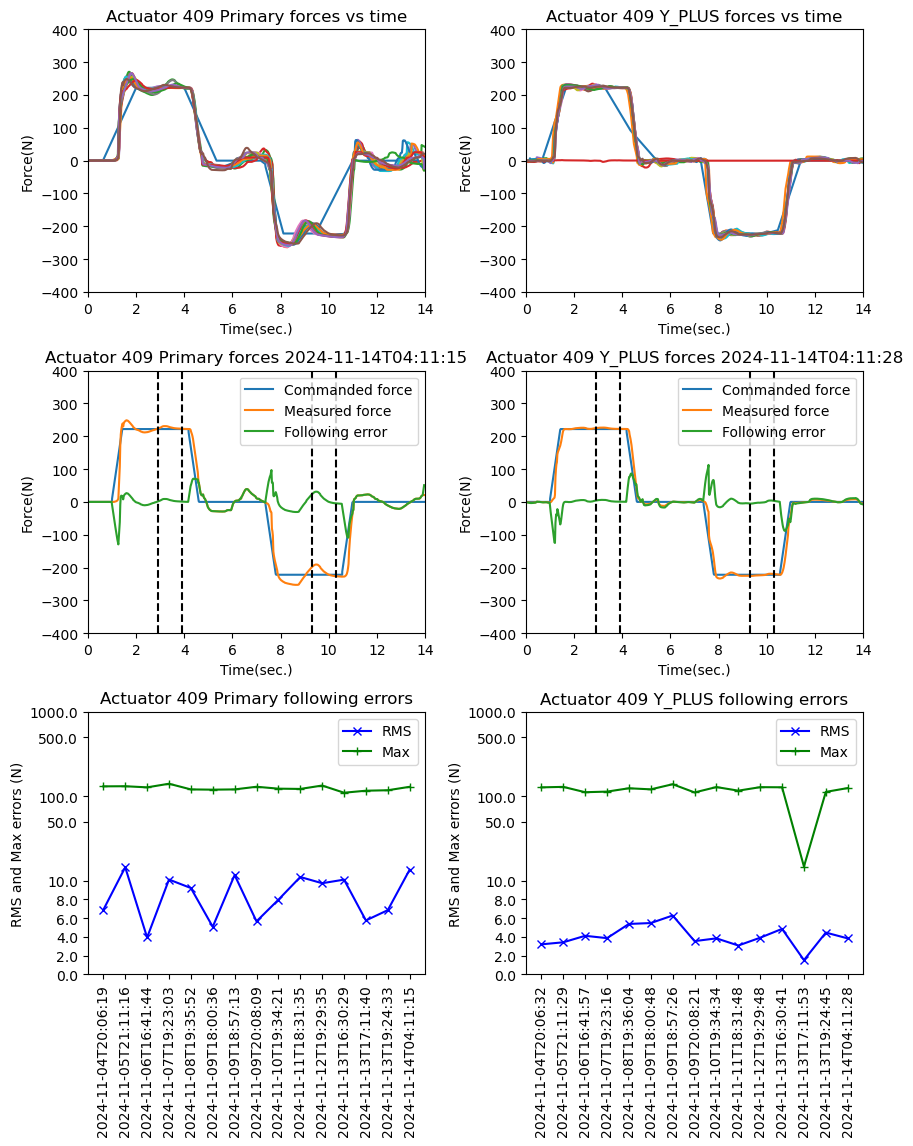

In [7]:
%matplotlib inline
client = EfdClient('usdf_efd')
bumps = await client.select_time_series("lsst.sal.MTM1M3.logevent_forceActuatorBumpTestStatus", "*",\
                                        Time(t_start, scale='utc'), Time(t_end, scale='utc'))
fig = plt.figure(figsize=(10,15))
await plot_actuator_error(fig, client, id, bumps)
plt.show()